### In this jupyter notebook we will show the effect of image degradation on ML/DL models to classify photovolataic cells 

In [3]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from elpv_reader import load_dataset
from imblearn.over_sampling import RandomOverSampler
import cv2
import cv
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import seaborn as sns
import random
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications import Xception, MobileNetV2
from keras.models import Model, Sequential
from keras.layers import Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Dense
from keras.utils import to_categorical
from keras import Input
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve,
    fbeta_score,
    make_scorer,
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)

In [12]:
def load_images_from_second_data_set(path_directory='/'.join(("C:","Users","kaci-", "dataset2")) ):
    def load_cell_image(fname):
        with Image.open(fname) as image:
            return np.asarray(image)
    
    labels2 = list()
    liste_name=['train', 'test']
    list_classes =['c0','c1','c2']
    for name in liste_name:
        for classe in list_classes:
            string = '/'.join((name,classe))
            for filename in os.listdir('/'.join((path_directory, string ))):
                if filename.endswith('jpg'):
                    if classe =='c2':
                        labels2.append(['/'.join((path_directory, string, filename )),2]) 
                    elif classe =='c1':
                        labels2.append(['/'.join((path_directory, string, filename )),1])
                    elif classe =='c0':
                        labels2.append(['/'.join((path_directory, string, filename )),0])
    
    dataframe_labels = pd.DataFrame(labels2, columns=['path', 'probability'])
    
    images = np.array([load_cell_image(fn) for fn in dataframe_labels['path']])
    proba = dataframe_labels['probability'].values
    return images, proba

In [18]:
images , labels  = load_images_from_second_data_set()
images_resized = np.array([cv2.resize(image, dsize=(100, 100), interpolation=cv2.INTER_CUBIC) for image in images])

Text(0.5, 1.0, 'histogram for the labels ')

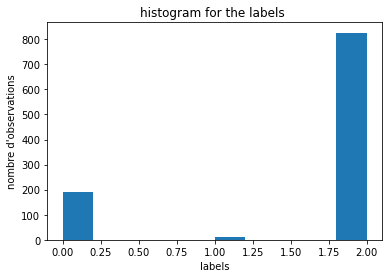

In [23]:
plt.hist(labels)
plt.xlabel('labels')
plt.ylabel("nombre d'observations")
plt.title('histogram for the labels ')

#### Cell without degradation 

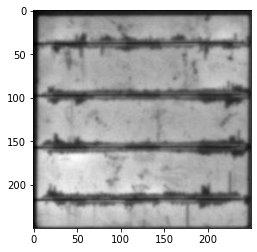

In [24]:
plt.gray()
plt.imshow( images[0] ) 

#### cell with a gaussian blur

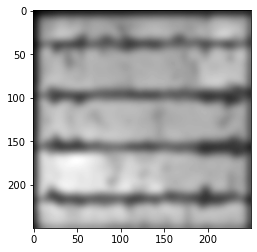

In [25]:
plt.imshow( gaussian_filter(images [0] ,sigma= 4)) 

#### cell with a horizontal motion blur 

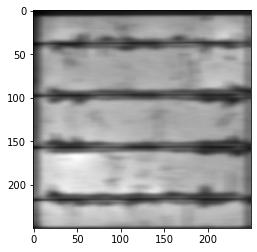

In [26]:
kernel_size = 15
kernel_h = np.zeros((kernel_size, kernel_size))
kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
kernel_h /= kernel_size
plt.imshow( cv2.filter2D(images[0] , -1, kernel_h)) 

#### cell with a vertical motion blur

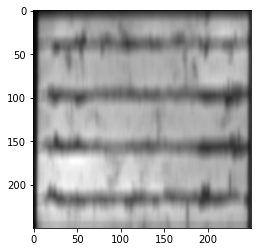

In [27]:
kernel_size =15
kernel_v = np.zeros((kernel_size, kernel_size)) 
kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size) 
kernel_v /= kernel_size
plt.imshow( cv2.filter2D(images[0] , -1, kernel_v)) 

In [20]:
def return_data_set_with_degradations(images, k_gaussian=1, sigma_gaussian=4, k_horizontal=1,k_vertical=1,
                                     kernel_amplitude= 15):
    
    random_indexes_g = random.choices(list(range(len(images))),k = k_gaussian)
    random_indexes_h = random.choices(list(range(len(images))),k = k_horizontal)
    random_indexes_v = random.choices(list(range(len(images))),k = k_vertical)
    
    
    # Gaussian blur
    for i in random_indexes_g:
        images[i] = gaussian_filter(images [i] ,sigma= np.random.uniform(1,sigma_gaussian))
    
    # Motion blur 
    for j in random_indexes_h:
        kernel_size = random.choice(list(range(1,kernel_amplitude)))
        kernel_h = np.zeros((kernel_size, kernel_size))
        kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
        kernel_h /= kernel_size
        images[j] = cv2.filter2D(images [j] , -1, kernel_h) 
    
    for k in random_indexes_v:
        kernel_size = random.choice(list(range(1,kernel_amplitude)))
        kernel_v = np.zeros((kernel_size, kernel_size)) 
        kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size) 
        kernel_v /= kernel_size
        images[k] = cv2.filter2D(images [k] , -1, kernel_v)
    
    
    return images

In [39]:
def create_model_vgg_rgb(shapex=100,shapey=100,dense=512):
    model = VGG16(include_top=False, input_shape=(shapex, shapey, 3))
    for layer in model.layers:
        layer.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(dense, activation='tanh')(flat1)
    output = Dense(3, activation='softmax')(class1)
    full_model = Model(inputs=model.inputs, outputs=output)
    return full_model

def create_model_vgg_gs(shapex=100, shapey=100, dense=512):
    model = VGG16(include_top=False)
    for layer in model.layers:
        layer.trainable = False
    input_tensor = Input(shape=(shapex,shapey,1) )
    x = Conv2D(3,(3,3),padding='same')(input_tensor)
    out = model(x)
    class1 = Dense(1024, activation='tanh')(out)
    flat1 = Flatten()(class1)
    output = Dense(3, activation='softmax')(flat1)
    full_model = Model(inputs=input_tensor, outputs=output)
    return full_model

def model_CNN():
    img_width, img_height = 100,100
    input_shape = (img_width, img_height, 3)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('tanh'))
    model.add(Dense(64))
    model.add(Activation('tanh'))
    model.add(Dense(32))
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

# Results without degradation

In [34]:
images = np.repeat(images_resized[..., np.newaxis], 3, -1)
labels = to_categorical(labels)
X_train, X_test , y_train, y_test = train_test_split(images, labels)

In [40]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model = model_CNN()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test),verbose=1)
_, acc = model.evaluate(X_test, y_test, verbose=1)

Train on 771 samples, validate on 257 samples
Epoch 1/30
771/771 [==============================] - 6s 8ms/step - loss: 0.5909 - accuracy: 0.7743 - val_loss: 0.2051 - val_accuracy: 0.9416
Epoch 2/30
771/771 [==============================] - 0s 500us/step - loss: 0.3237 - accuracy: 0.8988 - val_loss: 0.1369 - val_accuracy: 0.9922
Epoch 3/30
771/771 [==============================] - 0s 495us/step - loss: 0.2121 - accuracy: 0.9559 - val_loss: 0.0729 - val_accuracy: 0.9922
Epoch 4/30
771/771 [==============================] - 0s 494us/step - loss: 0.1679 - accuracy: 0.9741 - val_loss: 0.0543 - val_accuracy: 0.9922
Epoch 5/30
771/771 [==============================] - 0s 507us/step - loss: 0.1264 - accuracy: 0.9792 - val_loss: 0.0453 - val_accuracy: 0.9922
Epoch 6/30
771/771 [==============================] - 0s 537us/step - loss: 0.1135 - accuracy: 0.9831 - val_loss: 0.0414 - val_accuracy: 0.9922
Epoch 7/30
771/771 [==============================] - 0s 504us/step - loss: 0.1063 - accurac

In [42]:
def show_classification_results(classifier, x_test, y_test):
    y_pred_test = classifier.predict(x_test)
    print(classification_report(y_true=y_test, y_pred=to_categorical(np.argmax(y_pred_test,axis=1))))
    ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred_test,axis=1))).plot()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00       214

   micro avg       1.00      1.00      1.00       257
   macro avg       0.67      0.67      0.67       257
weighted avg       0.99      1.00      0.99       257
 samples avg       1.00      1.00      1.00       257



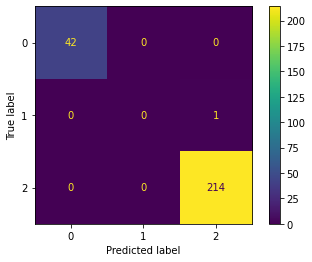

In [44]:
show_classification_results(model, X_test, y_test)

The classifier is near the perfect one ( the class 1 isn't really reprensentative , we need to leverage more data to have a better view of the class and/or use oversampling)

# Adding degradation

#### high degradation : 
  - gaussien blur : sigma between 1 and 5 
  - horizontal motion blur  with a  kernel between 1 and 15
  - vertical motion blur  with a  kernel between 1 and 15

In [46]:
images_degraded_full = return_data_set_with_degradations(images, k_gaussian=len(images), sigma_gaussian=5, k_horizontal=len(images),k_vertical=len(images),
                                     kernel_amplitude= 15)

Exemple 

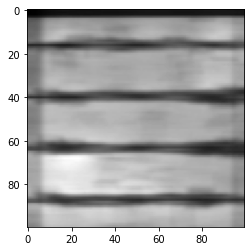

In [47]:
plt.imshow(images_degraded_full[0,:,:,0])

In [48]:
X_train, X_test , y_train, y_test = train_test_split(images_degraded_full, labels)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model = model_CNN()
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=80, batch_size=64, validation_data=(X_test, y_test),verbose=1)
_, acc = model.evaluate(X_test, y_test, verbose=1)

Train on 771 samples, validate on 257 samples
Epoch 1/80
771/771 [==============================] - 1s 854us/step - loss: 0.4005 - accuracy: 0.8495 - val_loss: 0.3320 - val_accuracy: 0.8729
Epoch 2/80
771/771 [==============================] - 0s 495us/step - loss: 0.3693 - accuracy: 0.8647 - val_loss: 0.3087 - val_accuracy: 0.8729
Epoch 3/80
771/771 [==============================] - 0s 499us/step - loss: 0.3320 - accuracy: 0.8681 - val_loss: 0.2675 - val_accuracy: 0.8729
Epoch 4/80
771/771 [==============================] - 0s 503us/step - loss: 0.2999 - accuracy: 0.8807 - val_loss: 0.2874 - val_accuracy: 0.8729
Epoch 5/80
771/771 [==============================] - 0s 507us/step - loss: 0.2915 - accuracy: 0.8820 - val_loss: 0.2487 - val_accuracy: 0.8729
Epoch 6/80
771/771 [==============================] - 0s 516us/step - loss: 0.2458 - accuracy: 0.9053 - val_loss: 0.3122 - val_accuracy: 0.9689
Epoch 7/80
771/771 [==============================] - 0s 494us/step - loss: 0.3174 - accur

771/771 [==============================] - 0s 485us/step - loss: 0.0609 - accuracy: 0.9896 - val_loss: 0.0643 - val_accuracy: 0.9844
Epoch 58/80
771/771 [==============================] - 0s 483us/step - loss: 0.0672 - accuracy: 0.9901 - val_loss: 0.0725 - val_accuracy: 0.9844
Epoch 59/80
771/771 [==============================] - 0s 474us/step - loss: 0.0667 - accuracy: 0.9892 - val_loss: 0.0566 - val_accuracy: 0.9883
Epoch 60/80
771/771 [==============================] - 0s 516us/step - loss: 0.0629 - accuracy: 0.9883 - val_loss: 0.0759 - val_accuracy: 0.9844
Epoch 61/80
771/771 [==============================] - 0s 507us/step - loss: 0.0652 - accuracy: 0.9905 - val_loss: 0.0735 - val_accuracy: 0.9844
Epoch 62/80
771/771 [==============================] - 0s 502us/step - loss: 0.0680 - accuracy: 0.9866 - val_loss: 0.0867 - val_accuracy: 0.9818
Epoch 63/80
771/771 [==============================] - 0s 499us/step - loss: 0.0650 - accuracy: 0.9892 - val_loss: 0.0737 - val_accuracy: 0.98

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        46
           1       0.00      0.00      0.00         3
           2       0.97      1.00      0.99       208

   micro avg       0.98      0.98      0.98       257
   macro avg       0.66      0.64      0.65       257
weighted avg       0.97      0.98      0.97       257
 samples avg       0.98      0.98      0.98       257



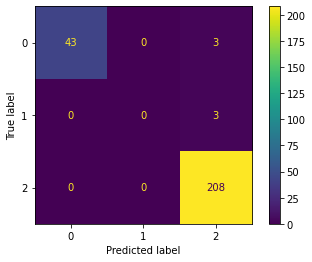

In [50]:
show_classification_results(model, X_test, y_test)

- a little degradation in the performances , let's see how the models are robust ? 

In [51]:
model = create_model_vgg_rgb(shapex=100,shapey=100,dense=512)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test),verbose=1)
_, acc = model.evaluate(X_test, y_test, verbose=1)

Train on 771 samples, validate on 257 samples
Epoch 1/30
771/771 [==============================] - 5s 6ms/step - loss: 0.2303 - accuracy: 0.9118 - val_loss: 0.1062 - val_accuracy: 0.9754
Epoch 2/30
771/771 [==============================] - 2s 2ms/step - loss: 0.0508 - accuracy: 0.9870 - val_loss: 0.0773 - val_accuracy: 0.9883
Epoch 3/30
771/771 [==============================] - 2s 2ms/step - loss: 0.0245 - accuracy: 0.9939 - val_loss: 0.0727 - val_accuracy: 0.9896
Epoch 4/30
771/771 [==============================] - 2s 2ms/step - loss: 0.0144 - accuracy: 0.9970 - val_loss: 0.0688 - val_accuracy: 0.9896
Epoch 5/30
771/771 [==============================] - 2s 2ms/step - loss: 0.0099 - accuracy: 0.9983 - val_loss: 0.0687 - val_accuracy: 0.9896
Epoch 6/30
771/771 [==============================] - 2s 2ms/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.0676 - val_accuracy: 0.9896
Epoch 7/30
771/771 [==============================] - 2s 2ms/step - loss: 0.0063 - accuracy: 0.9983 - 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        46
           1       0.00      0.00      0.00         3
           2       0.98      1.00      0.99       208

   micro avg       0.98      0.98      0.98       257
   macro avg       0.66      0.66      0.66       257
weighted avg       0.97      0.98      0.98       257
 samples avg       0.98      0.98      0.98       257



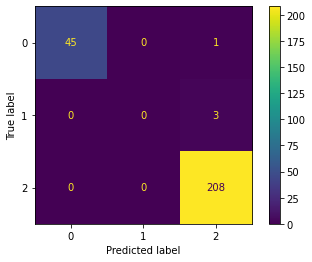

In [52]:
show_classification_results(model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.89      0.93        46
           1       1.00      0.33      0.50         3
           2       0.97      1.00      0.98       208

    accuracy                           0.97       257
   macro avg       0.98      0.74      0.80       257
weighted avg       0.97      0.97      0.97       257



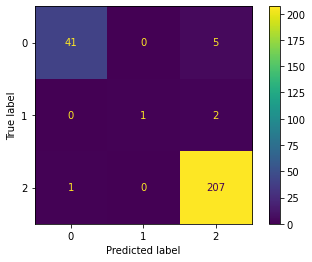

In [60]:
model = RandomForestClassifier().fit(X_train[:,:,:,0].reshape(len(X_train[:,:,:,0]),-1),np.argmax(y_train, axis=1))
show_classification_results(model,X_test[:,:,:,0].reshape(len(X_test[:,:,:,0]),-1), np.argmax(y_test, axis=1))

###  changing the degradation amplitude and see how it impacts random forest for example 

1- gaussian blur

In [66]:
def flou_impact(ml_model, images, proba):
    f1_scores = []
    accuracies = []
    for i in range(1,10):
        images_degraded = return_data_set_with_degradations(images, k_gaussian=len(images), sigma_gaussian=i, k_horizontal=len(images),
                                                            k_vertical=len(images),kernel_amplitude= 15)
        X_train_degraded, X_test_degraded, y_train, y_test = train_test_split(images_degraded, proba, random_state=11)
        model = ml_model.fit(X_train_degraded[:,:,:,0].reshape(len(X_train_degraded[:,:,:,0]),-1),y_train)
        y_pred = model.predict(X_test_degraded[:,:,:,0].reshape(len(X_test_degraded[:,:,:,0]),-1))
        #f1_scores.append(f1_score(y_test, y_pred))
        accuracies.append(accuracy_score(y_test, y_pred))
    return  accuracies

In [67]:
accuracies_rf = flou_impact(RandomForestClassifier(), images, np.argmax(labels, axis=1))

In [68]:
accuracies_lr = flou_impact(Pipeline([("Scaler", StandardScaler()), 
                  ("LR", LogisticRegression())]), images,  np.argmax(labels, axis=1))

In [69]:
accuracies_knn = flou_impact(Pipeline([("Scaler", StandardScaler()), 
                  ("LR", KNeighborsClassifier())]), images,  np.argmax(labels, axis=1))

Text(0.5, 1.0, 'accuracy for the models given the intensity of sigma for the gaussian filter')

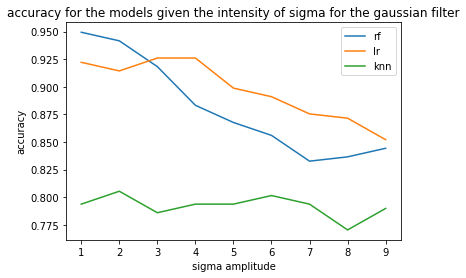

In [71]:
plt.plot(accuracies_rf, label='rf')
plt.plot(accuracies_lr, label='lr')
plt.plot(accuracies_knn, label='knn')
plt.legend()
plt.xlabel('sigma amplitude')
plt.ylabel('accuracy') 
plt.xticks(list(range(len(accuracies_rf))), list(range(1,10)))
plt.title('accuracy for the models given the intensity of sigma for the gaussian filter')

2- horizontal motion blur

In [73]:
def flou_mobile_horizontal_impact(ml_model, images, proba):
    f1_scores = []
    accuracies = []
    for i in range(2,11):
        images_degraded = return_data_set_with_degradations(images, k_gaussian=1, sigma_gaussian=3, k_horizontal=len(images),k_vertical=1,
                                                            kernel_amplitude= i*3)
        X_train_degraded, X_test_degraded, y_train, y_test = train_test_split(images_degraded, proba, random_state=11)
        model = ml_model.fit(X_train_degraded[:,:,:,0].reshape(len(X_train_degraded[:,:,:,0]),-1),y_train)
        y_pred = model.predict(X_test_degraded[:,:,:,0].reshape(len(X_test_degraded[:,:,:,0]),-1))
        #f1_scores.append(f1_score(y_test, y_pred))
        accuracies.append(accuracy_score(y_test, y_pred))
    return accuracies

In [74]:
accuracies_rf = flou_impact(RandomForestClassifier(), images, np.argmax(labels, axis=1))
accuracies_lr = flou_impact(Pipeline([("Scaler", StandardScaler()), 
                  ("LR", LogisticRegression())]), images,  np.argmax(labels, axis=1))
accuracies_knn = flou_impact(Pipeline([("Scaler", StandardScaler()), 
                  ("LR", KNeighborsClassifier())]), images,  np.argmax(labels, axis=1))

Text(0.5, 1.0, 'accuracy for the models given the intensity of kernel for the horizontal moving blur')

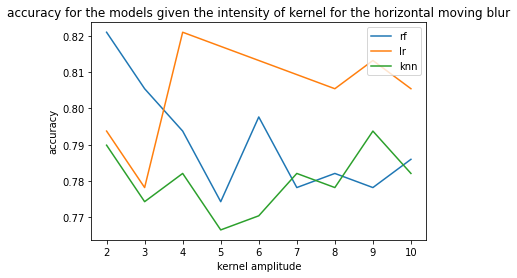

In [79]:
plt.plot(accuracies_rf, label='rf')
plt.plot(accuracies_lr, label='lr')
plt.plot(accuracies_knn, label='knn')
plt.legend()
plt.xlabel('kernel amplitude')
plt.ylabel('accuracy') 
plt.xticks(list(range(len(accuracies_rf))), list(range(2,11)))
plt.title('accuracy for the models given the intensity of kernel for the horizontal moving blur')

3- vertical motion blur

In [81]:
def flou_mobile_vertical_impact(ml_model, images, proba):
    f1_scores = []
    accuracies = []
    for i in range(2,11):
        images_degraded = return_data_set_with_degradations(images, k_gaussian=1, sigma_gaussian=3, k_horizontal=1,k_vertical=len(images),
                                                            kernel_amplitude= i*3)
        X_train_degraded, X_test_degraded, y_train, y_test = train_test_split(images_degraded, proba, random_state=11)
        model = ml_model.fit(X_train_degraded[:,:,:,0].reshape(len(X_train_degraded[:,:,:,0]),-1),y_train)
        y_pred = model.predict(X_test_degraded[:,:,:,0].reshape(len(X_test_degraded[:,:,:,0]),-1))
        #f1_scores.append(f1_score(y_test, y_pred))
        accuracies.append(accuracy_score(y_test, y_pred))
    return accuracies

In [82]:
accuracies_rf = flou_impact(RandomForestClassifier(), images, np.argmax(labels, axis=1))
accuracies_lr = flou_impact(Pipeline([("Scaler", StandardScaler()), 
                  ("LR", LogisticRegression())]), images,  np.argmax(labels, axis=1))
accuracies_knn = flou_impact(Pipeline([("Scaler", StandardScaler()), 
                  ("LR", KNeighborsClassifier())]), images,  np.argmax(labels, axis=1))

Text(0.5, 1.0, 'accuracy for the models given the intensity of kernel for the vertical moving blur')

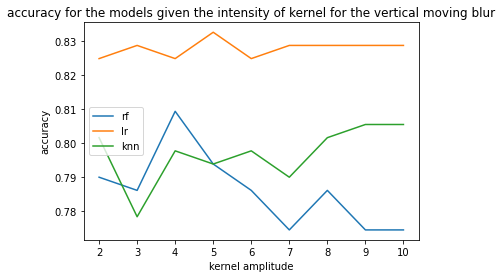

In [83]:
plt.plot(accuracies_rf, label='rf')
plt.plot(accuracies_lr, label='lr')
plt.plot(accuracies_knn, label='knn')
plt.legend()
plt.xlabel('kernel amplitude')
plt.ylabel('accuracy') 
plt.xticks(list(range(len(accuracies_rf))), list(range(2,11)))
plt.title('accuracy for the models given the intensity of kernel for the vertical moving blur')

- to be continued 